## PTSA final project

### Deal with dataset

In [1]:
!pip install --upgrade -q -r ptsa_req.txt
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from datetime import datetime
import seaborn as sns
# from darts.models.forecasting import arima
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy import optimize
from math import sqrt
import joblib
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')
from warnings import catch_warnings

palette = sns.color_palette("mako_r", 6)

You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


/home/tl2546/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tl2546/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/tl2546/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tl2546/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### utils

In [2]:
## search for the best model
# P <= 3, Q <= 1; p <= 3, q <= 27 -> impossible to solve for such a range. so truncate.
# Note large q won't work. Computationally expensive.

# modified utils from the following sources
# https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/
# https://www.kaggle.com/code/leandrovrabelo/climate-change-forecast-sarima-model/notebook

order_aic = [] # store AIC per model here. Complementary to CV
## currently not in use

# forecast function
def sarima_forecast(history, config, aic = True):
    """
    order = (p,d,q)
    sorder = (P,D,Q,s)
    """
    global order_aic
    order, sorder = config[:3], config[3:]
    # define model
    model = sarimax.SARIMAX(history, order=order,
                          seasonal_order=(0,0,0,0),
                          trend=None, enforce_stationarity=False,
                          enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False) # do not print convergence message
    # if aic:
    #   order_aic = order_aic + [(config, model_fit.aic)]
    #   print(f'Model {config}: {model_fit.aic}')
    # make one step forecast
    yhat = model_fit.predict(start = len(history), end = len(history))
    return yhat[-1]


# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(train, val, col, n_val, cfg):
        predictions = np.zeros(len(val))
        # seed history with training dataset
        history = list(train[col])
        val = list(val[col])
        # step over each time-step in the test set
        for i in tqdm(range(len(val))):
        # fit model and make forecast for history
            yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
            predictions[i] = yhat
        # add actual observation to history for the next loop
            history.append(val[i])
        # estimate prediction error
        error = measure_rmse(val, list(predictions))
        return error, predictions


# score a model, return None on failure
def score_model(train, val, col, n_val, cfg, debug=False, save = True):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result, preds = walk_forward_validation(train, val, col, n_val, cfg)
    else:
    #   try:
    # # never show warnings when grid searching, too noisy
    #       with catch_warnings():
    #         warnings.filterwarnings("ignore")
        result, preds = walk_forward_validation(train, val, col, n_val, cfg)
      # except:
      #     error = None
    # check for an interesting result
    if result is not None:
      print(' > Model[%s] %.4f' % (key, result))
    if save:
        np.save('~/arma_{key}_predictions.npy', predictions)
    return (key, result)


# we need to set to sarimax gridsearch
def grid_search(train, val, col, n_val, cfg_list, parallel=True):
    global order_aic
    scores = None
    if parallel:
    # execute configs in parallel
        executor = Parallel(n_jobs=-1, backend='multiprocessing')
        tasks = (delayed(score_model)(train, val, col, n_val, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(train, val, col, n_val, cfg) for cfg in cfg_list]
        # remove empty results
        scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda x: x[1])
    return scores



### Dataset

In [3]:
## Ithaca hourly data
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/hourly02-ithaca/hourly02-NY_Ithaca_13_E.csv'
Ithaca_hourly = pd.read_csv(url, index_col = 0)

## NYC central park data 1990-2023
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/nyc_daily/3508670.csv'
nyc_daily = pd.read_csv(url, delimiter=',')
nyc_daily.isnull().sum() # no missing values for TMIN, TMAX per day


STATION        0
NAME           0
DATE           0
ACMH       12357
AWND        2389
PRCP           0
SNOW           0
SNWD         834
TAVG        9710
TMAX           0
TMIN           0
TSUN        9472
WT01        8472
WT02       12000
WT03       12064
WT04       12306
WT05       12046
WT06       12283
WT07       12267
WT08       10433
WT09       12338
WT11       12353
WT13       10034
WT14       12126
WT15       12344
WT16        9104
WT17       12298
WT18       11767
WT19       12179
WT21       12357
WT22       12273
dtype: int64

##### Ithaca hourly

In [4]:
Ithaca_hourly = Ithaca_hourly.loc[:, ['UTC_DATE','UTC_TIME','T_HR_AVG']]
Ithaca_hourly.dropna(inplace = True)
Ithaca_hourly = Ithaca_hourly.reset_index().drop('index', axis = 1)
Ithaca_hourly

,UTC_DATE,UTC_TIME,T_HR_AVG
0,20041028,0,7.6
1,20041028,100,7.0
2,20041028,200,6.2
3,20041028,300,4.7
4,20041028,400,3.3
...,...,...,...
165308,20231106,0,1.3
165309,20231106,100,0.0
165310,20231106,200,-0.4
165311,20231106,300,-1.3


In [5]:
Date = (pd.to_datetime(Ithaca_hourly.UTC_DATE, format='%Y%m%d', errors='coerce')
+ pd.to_timedelta(Ithaca_hourly.UTC_TIME//100, unit = 'hours'))

Ithaca_hourly['Time'] = Date
Ithaca_hourly.to_json('Ithaca_hourly.json')

##### Ithaca daily

In [6]:
Ithaca_daily = pd.DataFrame(Ithaca_hourly.groupby(Ithaca_hourly.Time.dt.date)['T_HR_AVG'].mean())
Ithaca_daily = Ithaca_daily.rename(columns = {'T_HR_AVG':'T_AVG'}).reset_index()
Ithaca_daily.Time = pd.to_datetime(Ithaca_daily.Time, format = '%Y-%m-%d', errors = 'coerce')
Ithaca_daily

,Time,T_AVG
0,2004-10-28,5.520833
1,2004-10-29,7.712500
2,2004-10-30,13.116667
3,2004-10-31,14.233333
4,2004-11-01,7.687500
...,...,...
6904,2023-11-02,0.233333
6905,2023-11-03,5.375000
6906,2023-11-04,9.804167
6907,2023-11-05,7.037500


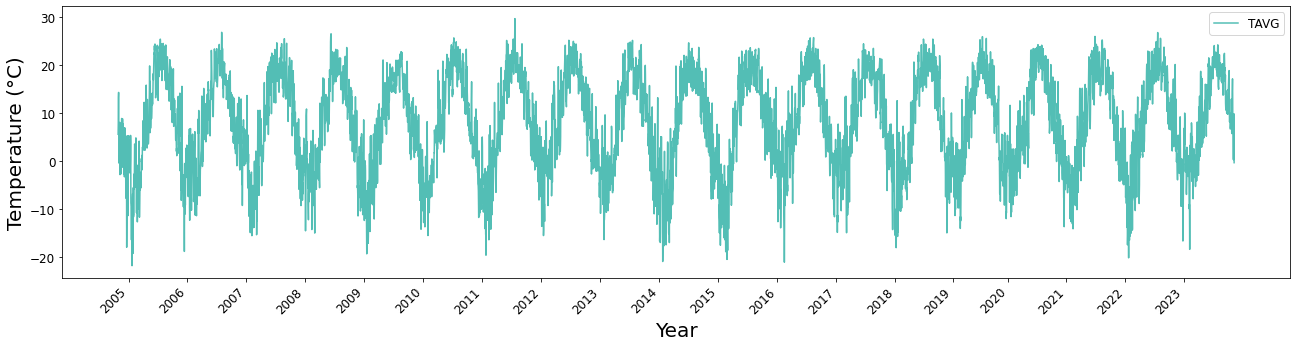

In [7]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = Ithaca_daily.shape[0]
# find beginning of each year, used for xtick labels
years_txt, years = np.unique(Ithaca_daily.Time.dt.year, return_index = True)

fig_overall, ax = plt.subplots(1,1, figsize = (22,5))
sns.lineplot(x = Ithaca_daily.index[:interval], y = Ithaca_daily['T_AVG'][:interval],
              color = palette[1], label = 'TAVG', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks(years[1:]) # 2004 collapsed...
ax.set_xticklabels(years_txt[1:], rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°C)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)
ax.legend(fontsize = 12)
plt.show()

##### NYC daily

In [8]:
Date = pd.to_datetime(nyc_daily.DATE, format='%Y-%m-%d', errors='coerce')
nyc_daily['year'], nyc_daily['month'], nyc_daily['day'] = Date.dt.year, Date.dt.month, Date.dt.day
nyc_daily

,STATION,NAME,DATE,ACMH,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT15,WT16,WT17,WT18,WT19,WT21,WT22,year,month,day
0,USW00094728,"NY CITY CENTRAL PARK, NY US",1990-01-01,NaN,NaN,0.24,0.0,0.0,NaN,48,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1990,1,1
1,USW00094728,"NY CITY CENTRAL PARK, NY US",1990-01-02,NaN,NaN,0.00,0.0,0.0,NaN,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1,2
2,USW00094728,"NY CITY CENTRAL PARK, NY US",1990-01-03,NaN,NaN,0.00,0.0,0.0,NaN,53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1,3
3,USW00094728,"NY CITY CENTRAL PARK, NY US",1990-01-04,NaN,NaN,0.01,0.0,0.0,NaN,51,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1990,1,4
4,USW00094728,"NY CITY CENTRAL PARK, NY US",1990-01-05,NaN,NaN,0.00,0.0,0.0,NaN,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12353,USW00094728,"NY CITY CENTRAL PARK, NY US",2023-10-28,NaN,4.92,0.00,0.0,0.0,NaN,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,28
12354,USW00094728,"NY CITY CENTRAL PARK, NY US",2023-10-29,NaN,6.93,0.47,0.0,0.0,NaN,63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,29
12355,USW00094728,"NY CITY CENTRAL PARK, NY US",2023-10-30,NaN,4.47,0.59,0.0,0.0,NaN,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,30
12356,USW00094728,"NY CITY CENTRAL PARK, NY US",2023-10-31,NaN,3.80,0.00,0.0,0.0,NaN,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,31


In [9]:
nyc_daily_drop = nyc_daily.set_index('DATE').drop(['STATION','NAME', 'ACMH', 'TAVG', 'TSUN', 'AWND'],
                                                  axis =1) # drop since single station, tavg, tsun too many missing values
nyc_daily_drop.drop(nyc_daily_drop.columns[[i.startswith('WT') for \
                                            i in nyc_daily_drop.columns]], axis = 1, inplace = True)
nyc_daily = nyc_daily_drop.reset_index().drop('DATE', axis = 1)

### Plot

#### Plot functions (run before proceed)

In [10]:
## naive version
def plot_triple(df, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)

    ax2.stem(acf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated ACF')
    ax2.fill_between(np.arange(1, n_lags_ar + 1), acf_error_estimate, -acf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels([f'{int(i)}' for i in ax2.get_xticks()], rotation=45, ha='right')
    ax2.legend(fontsize=fontsize)

    ax3.stem(pacf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated PACF')
    ax3.fill_between(np.arange(1, n_lags_ma + 1), pacf_error_estimate, -pacf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels([f'{int(i)}' for i in ax3.get_xticks()], rotation=45, ha='right')
    ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{fig_name}.png')

In [11]:
## built-in plot_pcaf, plot_acf
def plot_triple_built_in(df, n_lags_ar, n_lags_ma, seasonality, lag_ma, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)


    plot_acf(df[col], lags = np.arange(n_lags_ar)[::seasonality], ax = ax2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels([f'{int(i)}' for i in ax2.get_xticks()], rotation=45, ha='right')
    # ax2.legend(fontsize=fontsize)

    plot_pacf(df[col], lags = np.arange(n_lags_ma)[::lag_ma], ax = ax3)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels([f'{int(i)}' for i in ax3.get_xticks()], rotation=45, ha='right')
    # ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{fig_name}.png')

In [12]:
## forecast plot
def plot_forecast(X_train, X_val, preds, n_from_train_end, n_from_val_start, col, pred_col, save = False):
    fig, ax = plt.subplots(1, 1, figsize=(22, 5), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)
    
    X_train_trunc = X_train[-n_from_train_end:]
    X_val_trunc = X_val[:n_from_val_start]
    df = pd.concat([X_train_trunc, X_val_trunc], axis = 0)
    X_pred = pd.DataFrame(preds.squeeze(1)[:n_from_val_start], columns = [pred_col], index = X_val_trunc.index)
    X_pred['Time'] = X_val_trunc.Time
    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax.set_title('Forecast', fontsize=fontsize)
    sns.lineplot(x=X_train_trunc.index, y=X_train_trunc[col],
                 color=palette[1], lw = 1, label= f'Train_{col}', alpha=0.9, ax=ax)
    sns.lineplot(x=X_val_trunc.index, y=X_val_trunc[col],
                 color=palette[1], lw = 1, label= f'Val_{col}', alpha=0.9, ax=ax)
    sns.lineplot(x=X_pred.index, y=X_pred[pred_col],
                 color=palette[-1], lw = 1, label= f'Pred_{pred_col}', alpha=1, ax=ax)
    ax.set_xticklabels([])
    ax.set_xticks(years[1:])
    ax.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax.legend(fontsize=12)
    if save:
        fig.savefig(f'pred_{n_from_train_end}_{n_from_val_start}.png', bbox_inches = 'tight')

###### NYC daily

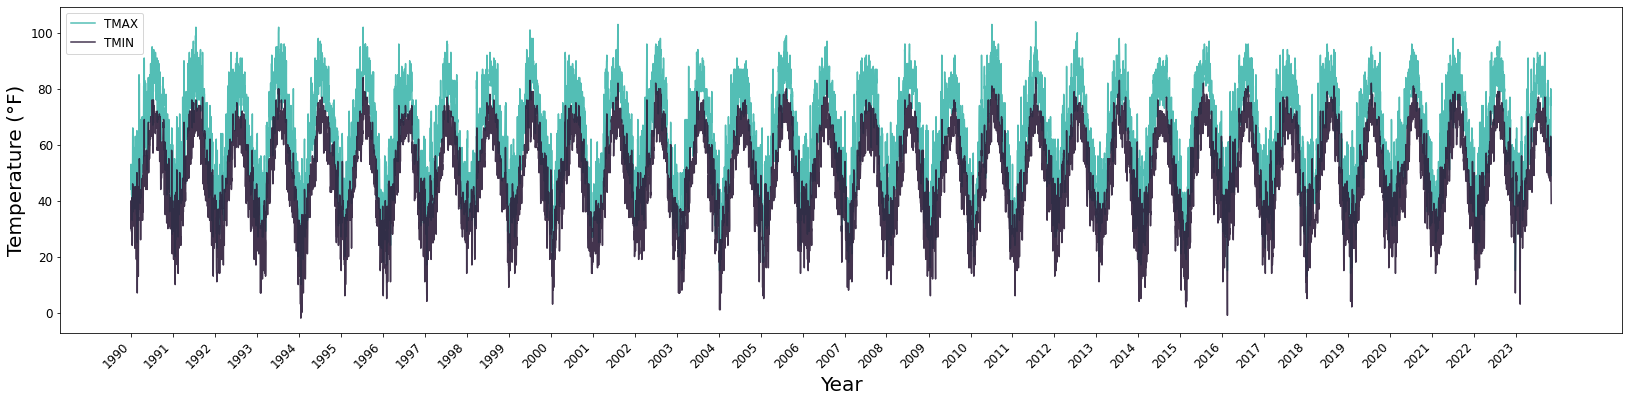

In [13]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = nyc_daily.shape[0]
years_txt, years = np.unique(nyc_daily.year, return_index = True)


fig_overall, ax = plt.subplots(1,1, figsize = (28,6))
sns.lineplot(x = nyc_daily.index[:interval], y = nyc_daily['TMAX'][:interval],
              color = palette[1], label = 'TMAX', alpha = 0.9)
sns.lineplot(x = nyc_daily.index[:interval], y = nyc_daily['TMIN'][:interval],
              color = palette[-1], label = 'TMIN', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xticks(years)
ax.set_xticklabels(years_txt, rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°F)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)

ax.legend(fontsize = 12)
plt.show()
# we see clear cyclic pattern

##### Ithaca hourly

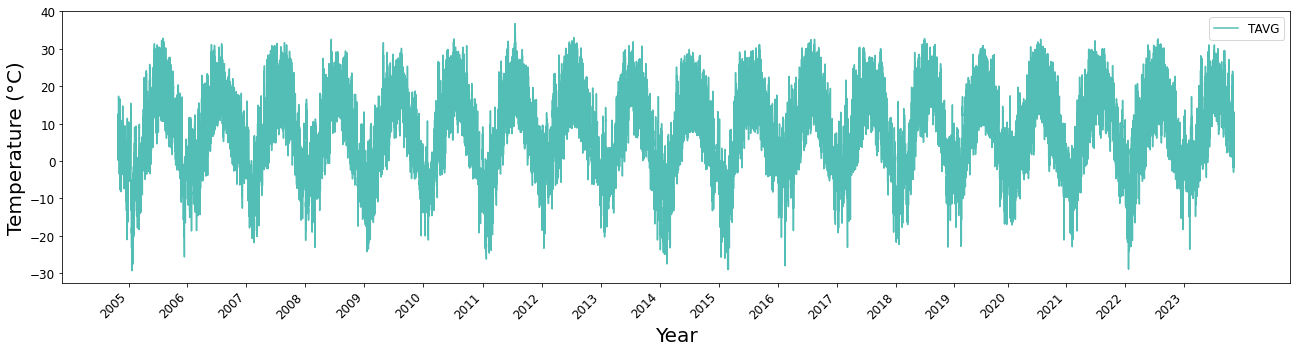

In [14]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = Ithaca_hourly.shape[0]
# find beginning of each year, used for xtick labels
years_txt, years = np.unique(Ithaca_hourly.Time.dt.year, return_index = True)

fig_overall, ax = plt.subplots(1,1, figsize = (22,5))
sns.lineplot(x = Ithaca_hourly.index[:interval], y = Ithaca_hourly['T_HR_AVG'][:interval],
              color = palette[1], label = 'TAVG', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks(years[1:]) # 2004 collapsed...
ax.set_xticklabels(years_txt[1:], rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°C)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)
ax.legend(fontsize = 12)
plt.show()
# we see clear cyclic pattern
# Hourly plot is more noisy. but I think both work.

### Initial Model

#### 0. train val split

In [15]:
### train val split: ~ 8:2
Ithaca_hourly_train = Ithaca_hourly[Ithaca_hourly.Time.dt.year < 2020]
Ithaca_hourly_val = Ithaca_hourly[Ithaca_hourly.Time.dt.year >=2020]
print(f'training set length = {Ithaca_hourly_train.shape[0]}\n val set length = {Ithaca_hourly_val.shape[0]}')

training set length = 131871
 val set length = 33442


#### 1. look at ACF, PACF, run KPSS, ADF test for stationarity

In [16]:
### Determine dependence order by plotting ACF
n_lags_ar = 365*24*10
n_lags_ma = 365
acf_sm = acf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ar)
pacf_sm = pacf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ma)

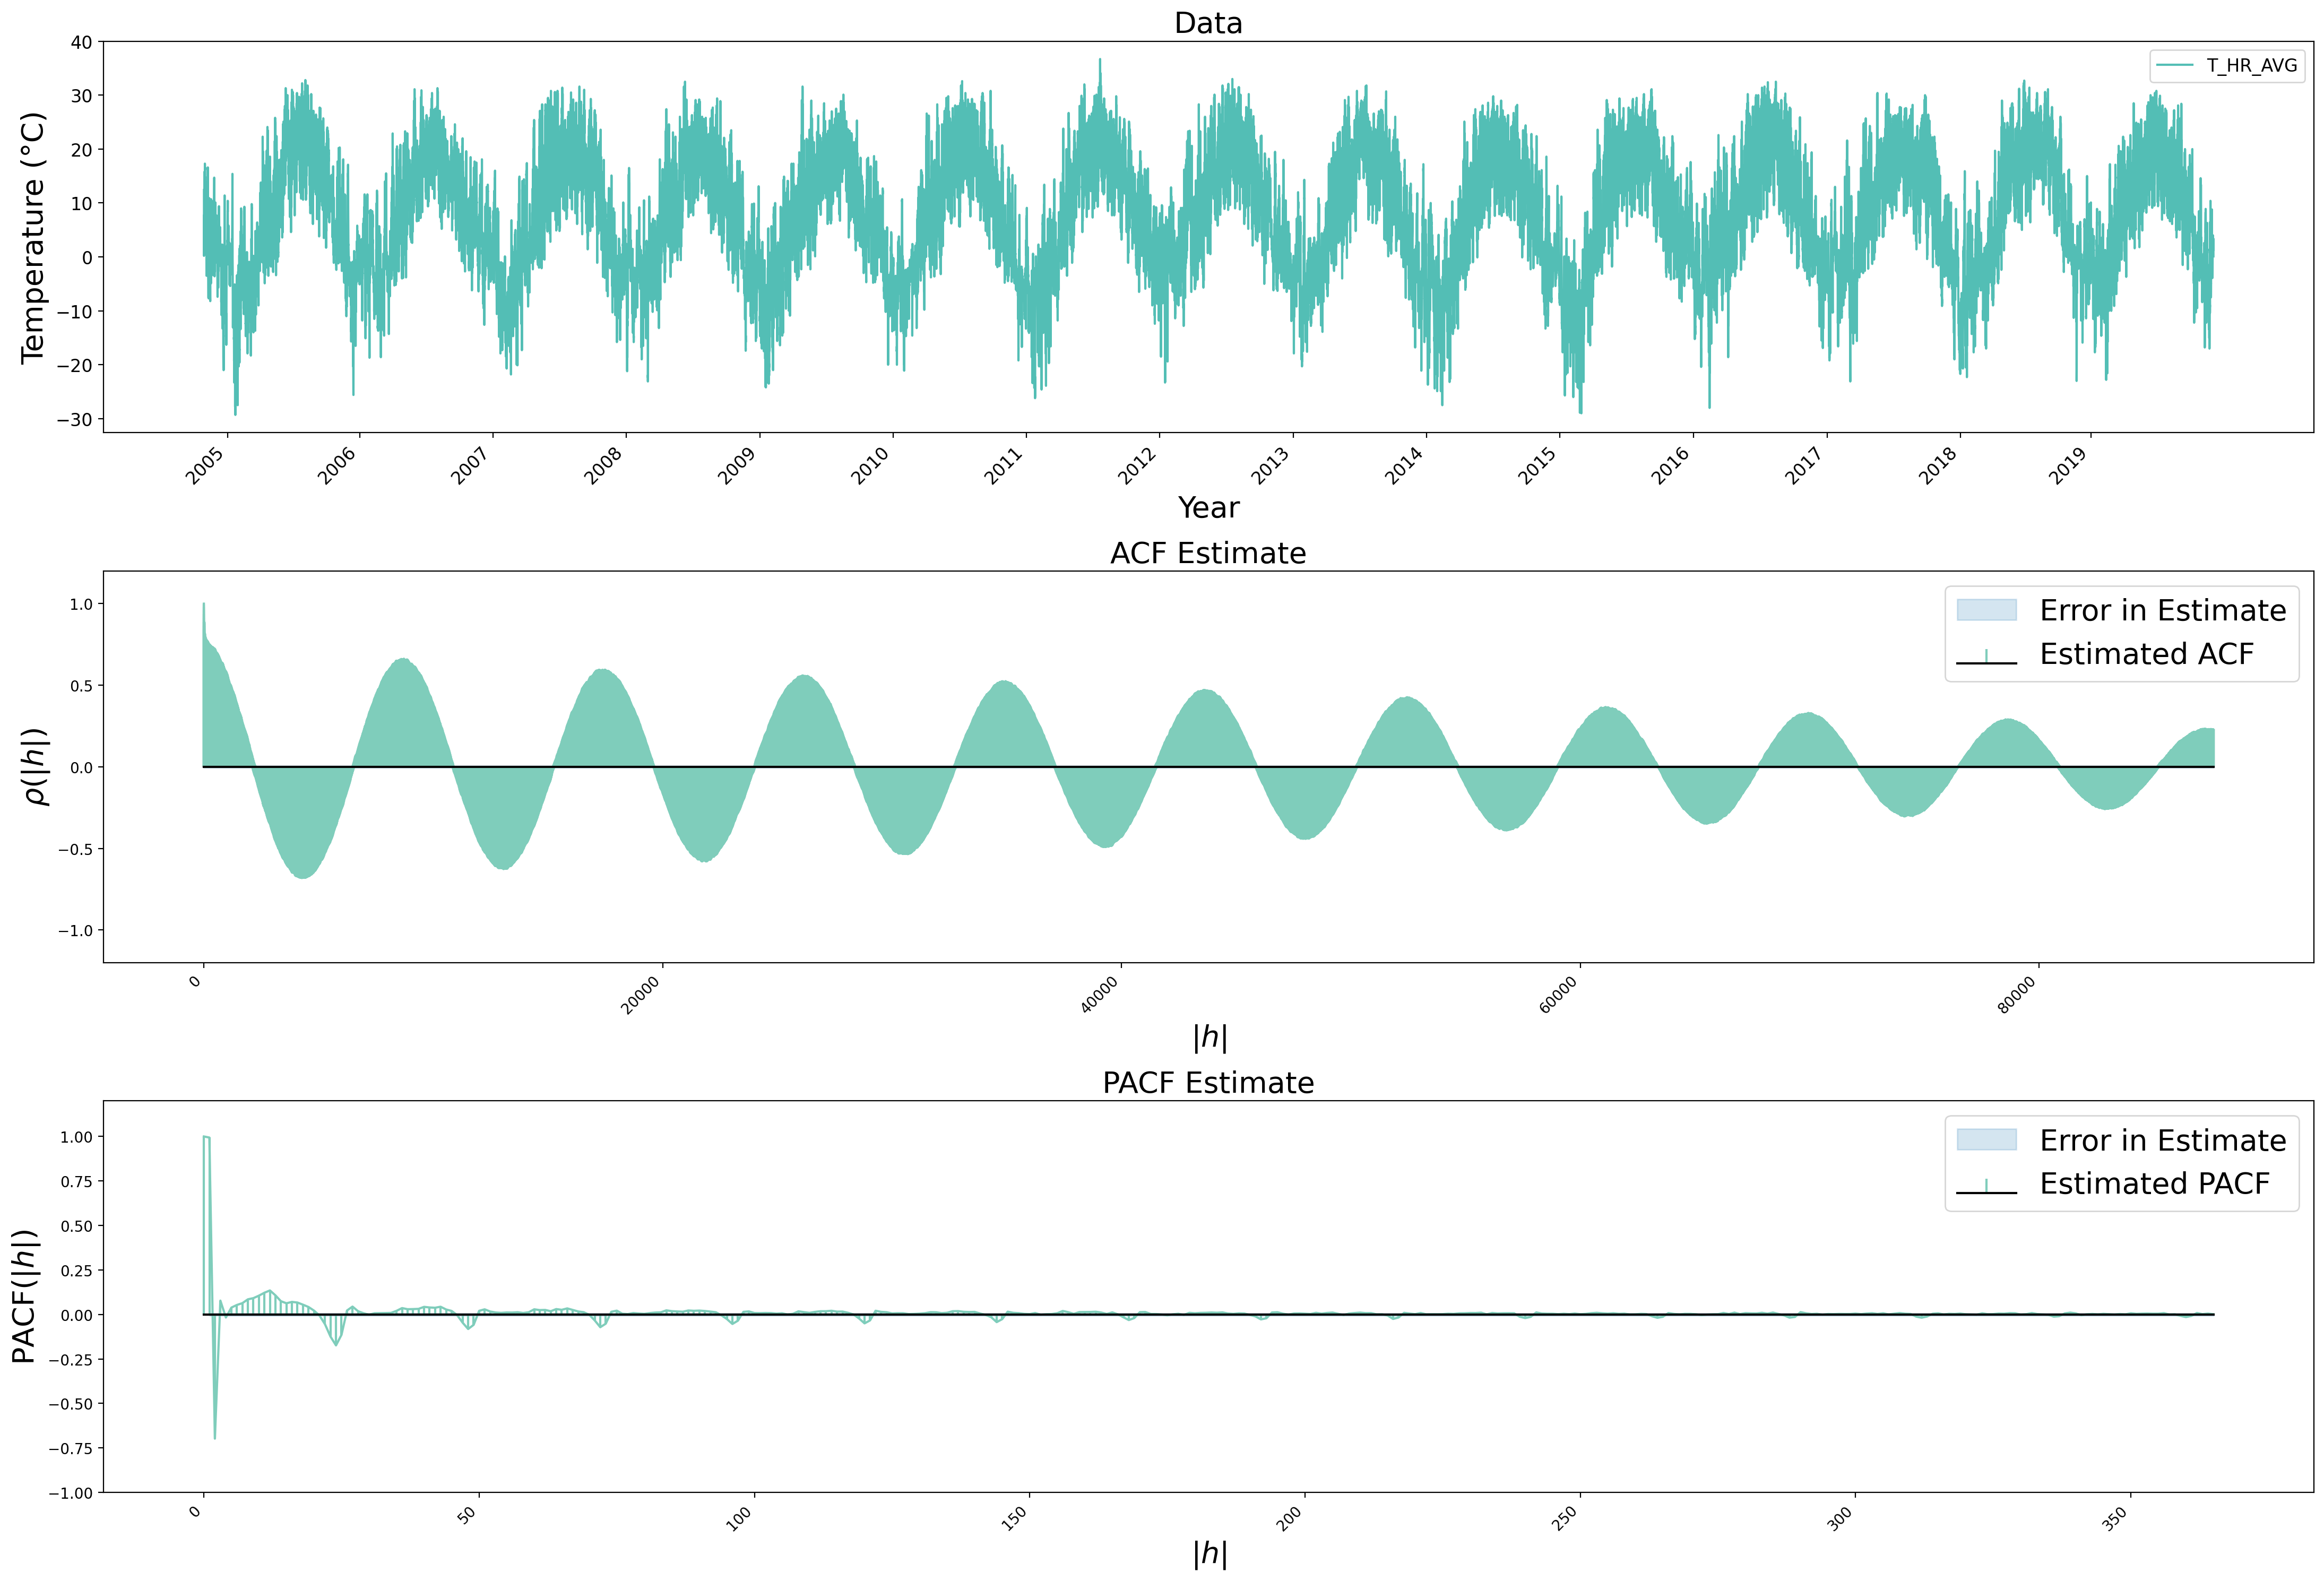

In [17]:
### Plot
plot_triple(Ithaca_hourly_train, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col = 'T_HR_AVG', fig_name = 'raw_data')

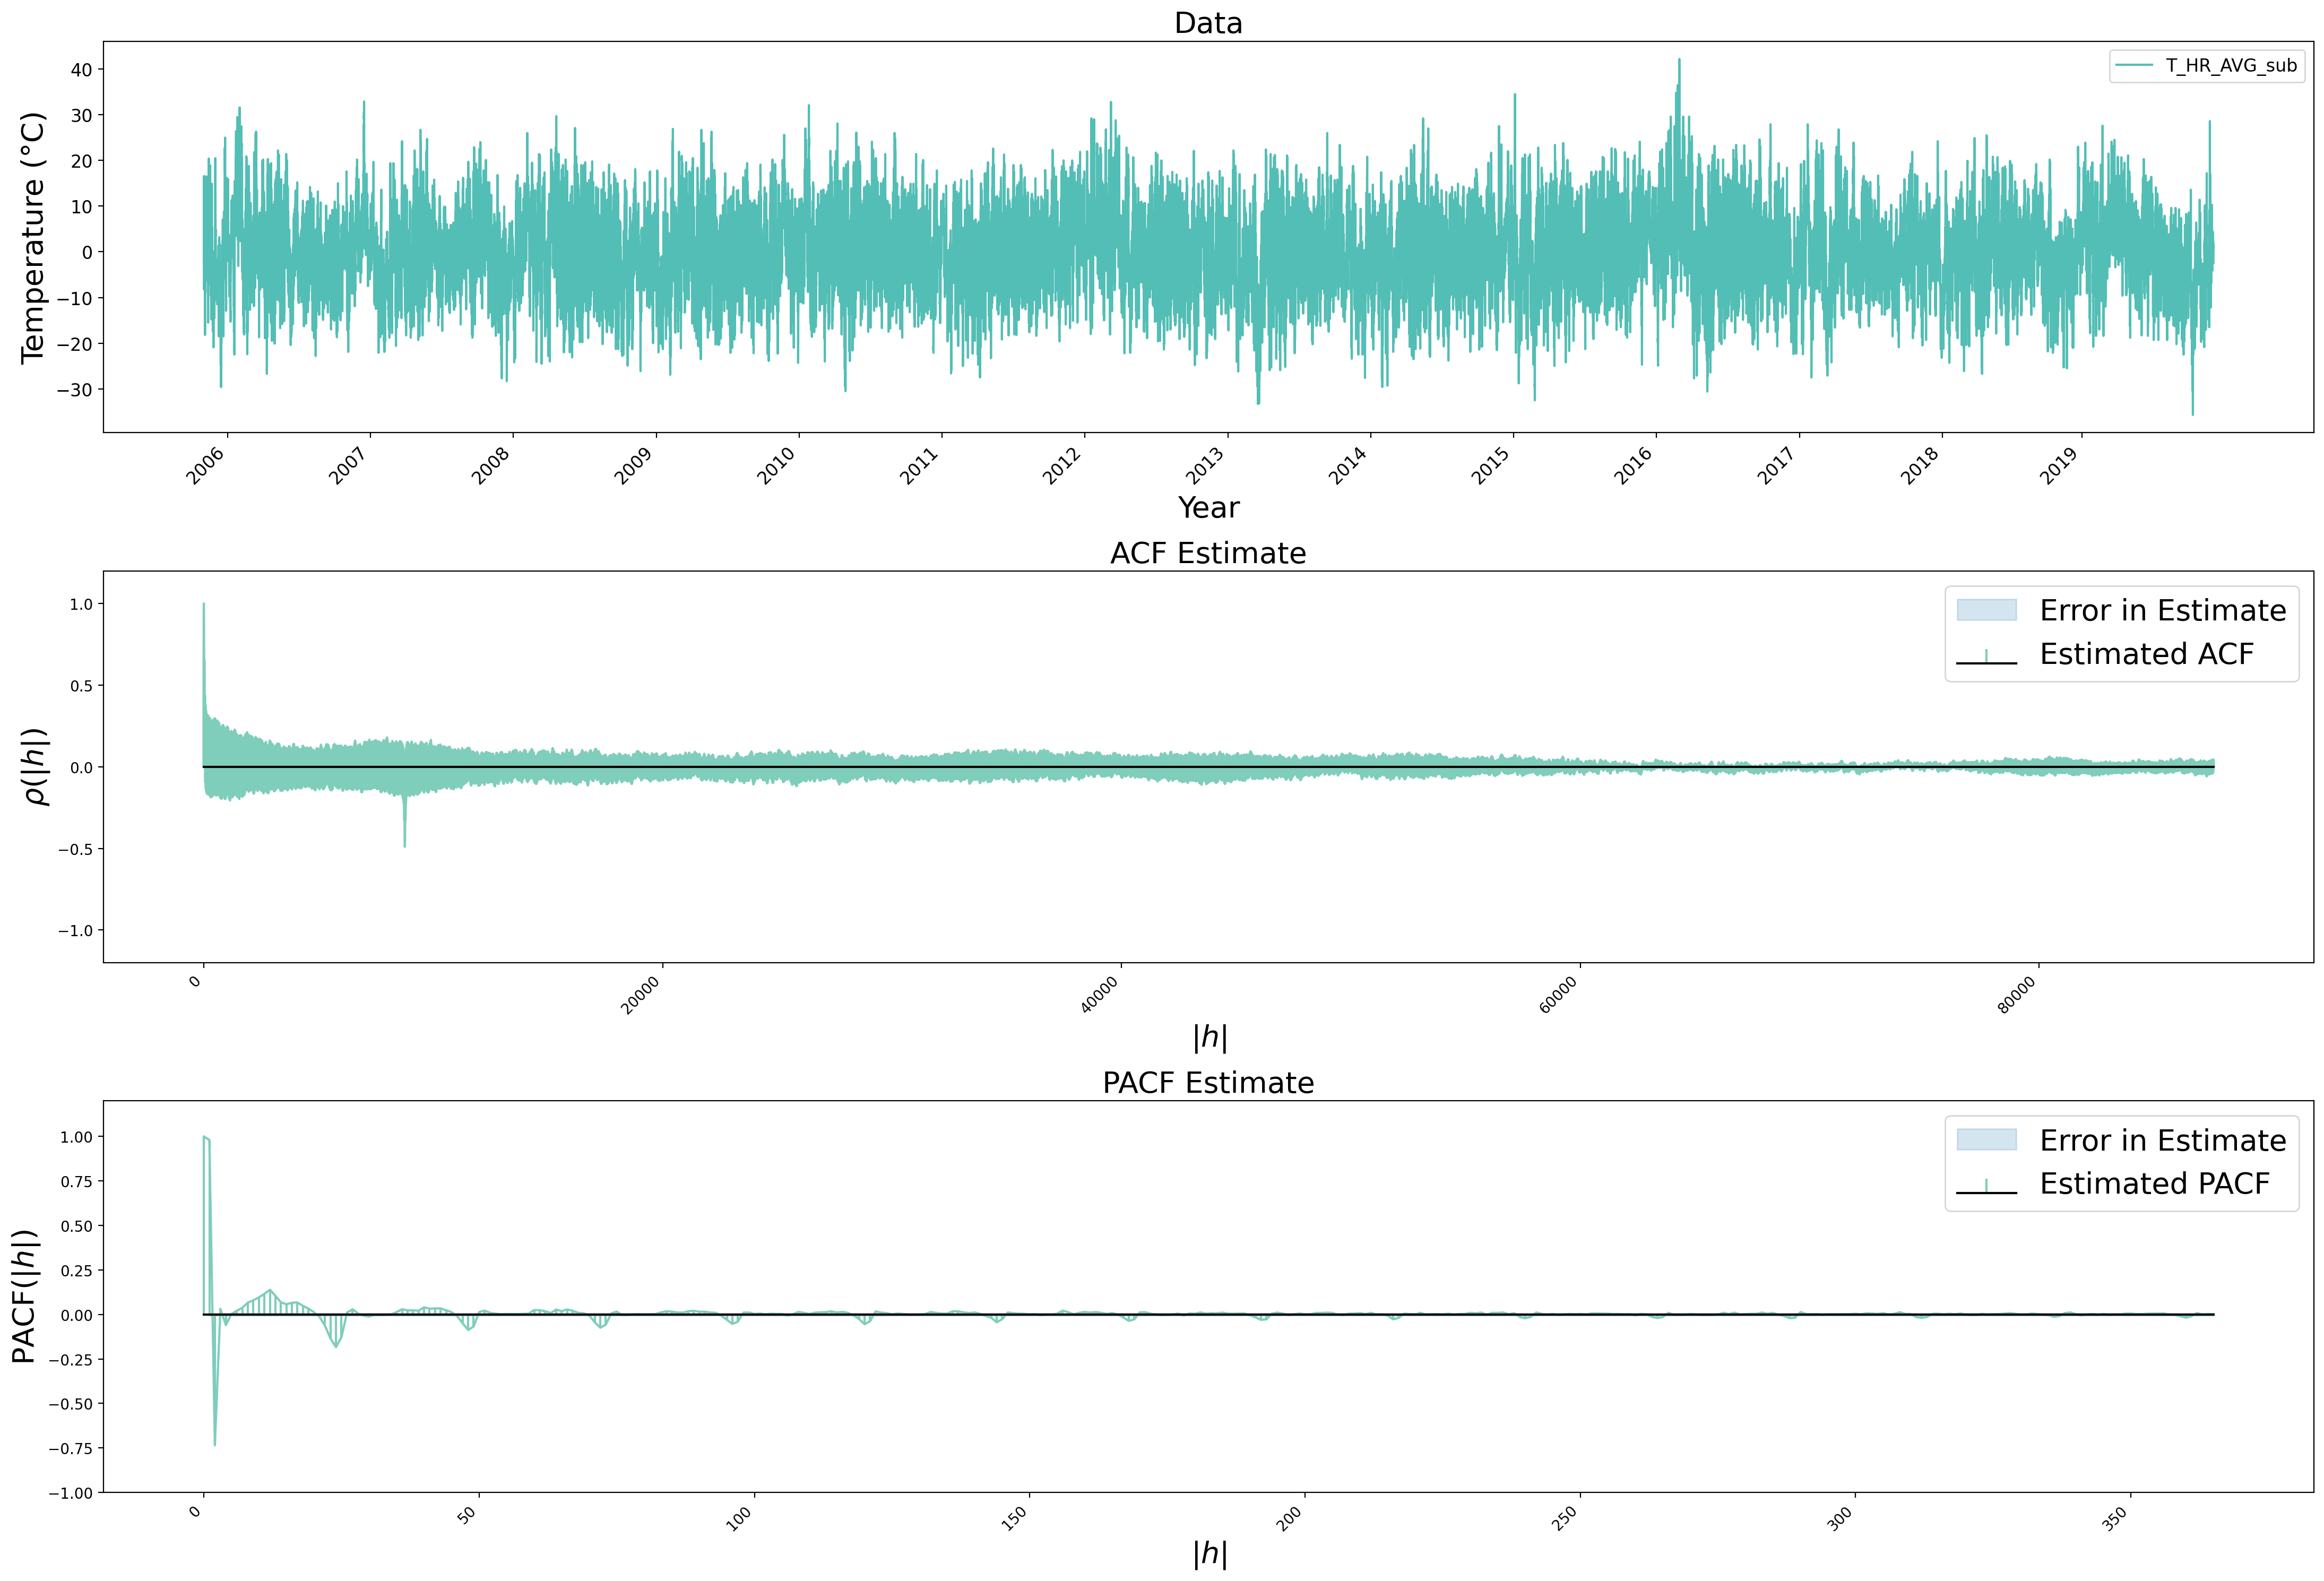

In [18]:
### plot without seasonality
# suggest seasonality of 356*24 = 8760
# let's remove seasonality by subtraction, as per pts4
seasonality = 8760
Ithaca_hourly_train_no_season = Ithaca_hourly_train.join(pd.DataFrame(Ithaca_hourly_train.T_HR_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()
n_lags_ar = 365*24*10
n_lags_ma = 365
acf_no_season_sm = acf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ar)
pacf_no_season_sm = pacf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ma)

plot_triple(Ithaca_hourly_train_no_season, n_lags_ar, n_lags_ma, acf_sm = acf_no_season_sm,
            pacf_sm = pacf_no_season_sm, col = 'T_HR_AVG_sub', fig_name = 'drop_seasonality')

In [19]:
### check stationarity
adfuller(Ithaca_hourly_train_no_season.T_HR_AVG_sub) # seem to be stationary

(-29.73253901386201,
 0.0,
 72,
 123038,
 {'1%': -3.4304031497296332,
  '5%': -2.861563491396274,
  '10%': -2.5667825036397725},
 365694.86750573805)

#### 2. Deal with P, Q (seasonal AR & MA), as per [pts4](http://www.stat.ucla.edu/~frederic/221/W21/tsa4.pdf)
- Seems to lead to more satisfactory results if deal with seasonal first

In [20]:
seasonality = 8760
# acf_seasonal = acf_no_season_sm[::seasonality]
# pacf_seasonal = pacf(Ithaca_hourly_train_no_season.T_HR_AVG_sub,  nlags = seasonality//10) # really computationally expensive

In [ ]:
## plot
plot_triple_built_in(df = Ithaca_hourly_train_no_season,
                     n_lags_ar = seasonality * 10, n_lags_ma = 24*100,
                     seasonality = seasonality,
                     col = 'T_HR_AVG_sub',fig_name = 'seasonal_P_Q')
# suggests Q <=1, but P? suggests 0 AR(P)? Let's just try it. Or take a look at daily?

#### 3. Deal with daily

##### 3.1 take a look at daily TAVG to determine AR(P) (i.e., seasonal autoregressive process)

In [22]:
Ithaca_daily.Time = pd.to_datetime(Ithaca_daily.Time, format = '%Y-%m-%d', errors = 'coerce')
Ithaca_daily_train = Ithaca_daily[Ithaca_daily.Time.dt.year < 2020]
Ithaca_daily_val = Ithaca_daily[Ithaca_daily.Time.dt.year >=2020]
print(f'training set length = {Ithaca_daily_train.shape[0]}\n val set length = {Ithaca_daily_val.shape[0]}')

training set length = 5510
 val set length = 1399


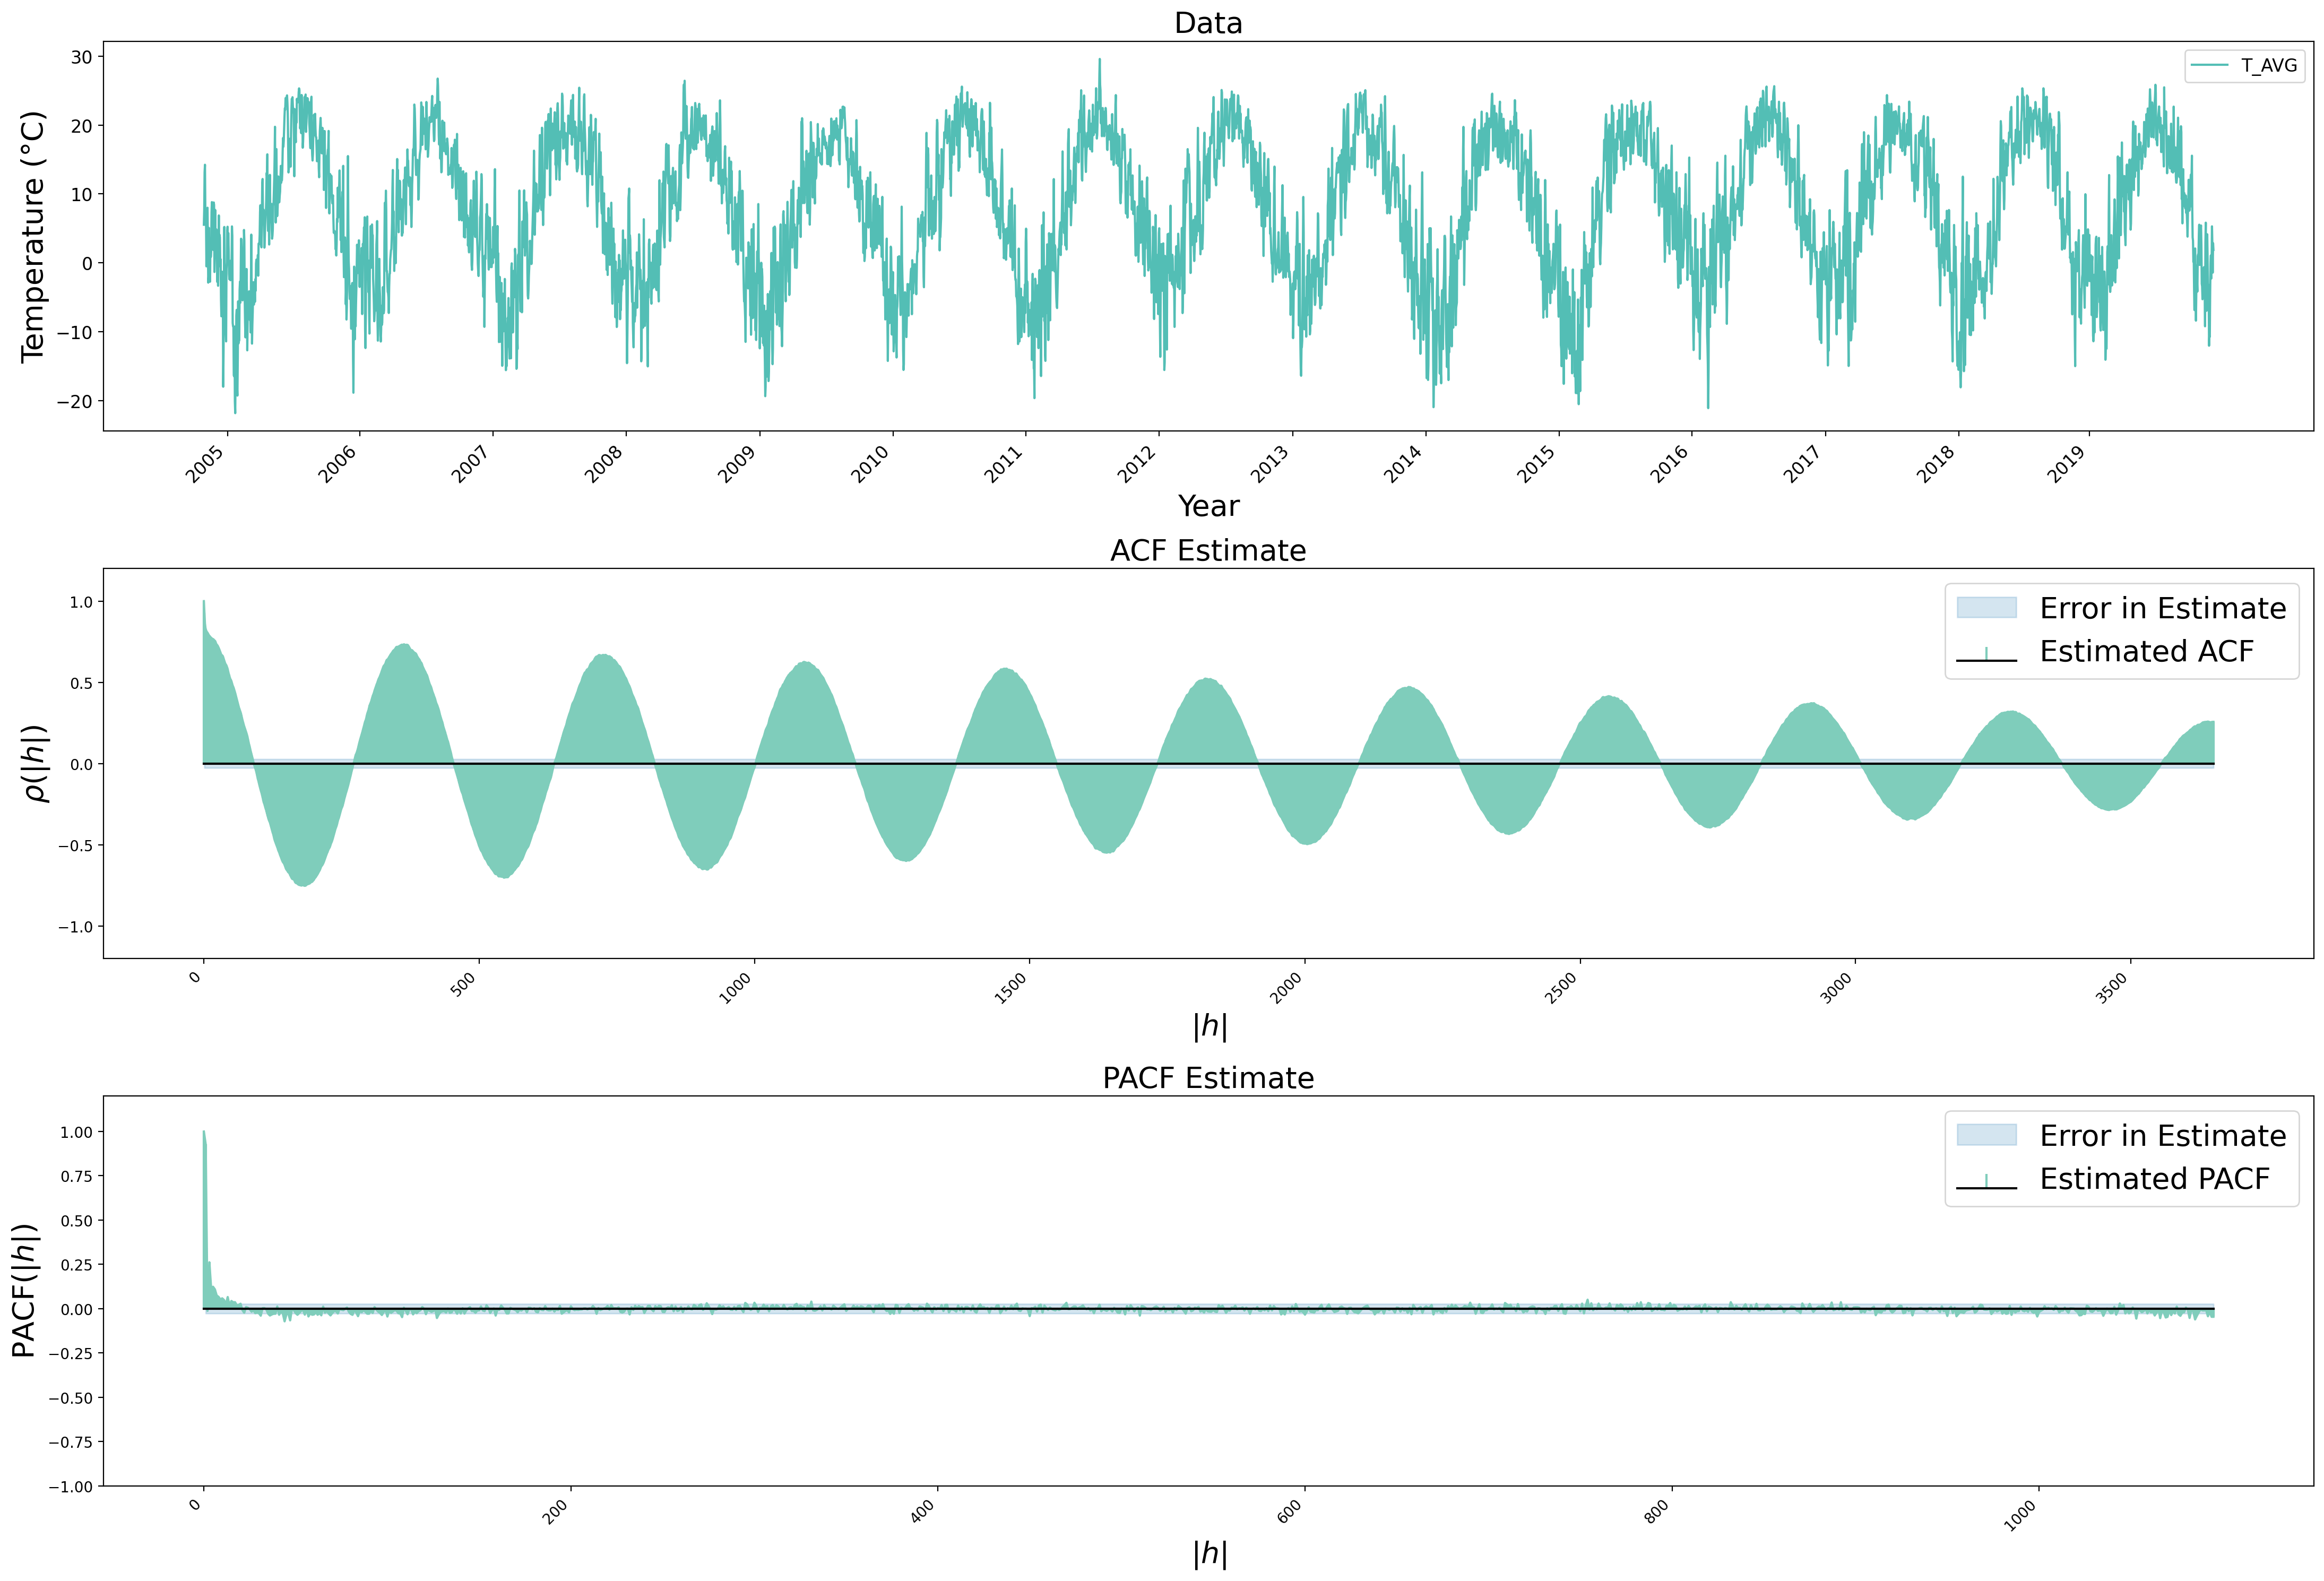

In [23]:
n_lags_ar = 365*10
n_lags_ma = 365*3
acf_daily_sm = acf(Ithaca_daily_train.T_AVG, nlags = n_lags_ar)
pacf_daily_sm = pacf(Ithaca_daily_train.T_AVG, nlags = n_lags_ma)

plot_triple(Ithaca_daily_train, n_lags_ar, n_lags_ma, acf_sm = acf_daily_sm,
            pacf_sm = pacf_daily_sm, col = 'T_AVG', fig_name = 'Ithaca_daily_raw')

In [24]:
seasonality = 365
Ithaca_daily_train_no_season = Ithaca_daily_train.join(pd.DataFrame(Ithaca_daily_train.T_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()

adfuller(Ithaca_daily_train_no_season.T_AVG_sub) # seem to be stationary

(-11.624643547320375,
 2.339505390270946e-21,
 19,
 5125,
 {'1%': -3.4316266006519593,
  '5%': -2.862104122472345,
  '10%': -2.5670702825556218},
 30617.925638196415)

In [ ]:
## Do not run. just keep the output

## plot
plot_triple_built_in(df = Ithaca_daily_train_no_season,
                     n_lags_ar = seasonality * 8, n_lags_ma = seasonality * 8,
                     seasonality = seasonality, lag_ma = seasonality,
                     col = 'T_AVG_sub',fig_name = 'daily_p_q')

# daily plot suggests Q <=1 & P <= 3, reducing our search space.

In [ ]:
## Let's also draw acf & pacf in one cycle
plot_triple_built_in(df = Ithaca_daily_train_no_season,
                     n_lags_ar = seasonality, n_lags_ma = seasonality,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_AVG_sub',fig_name = 'daily_seasonal_P_Q')
## suggest MA(q): q<=26/7? AR(p): p<=3?

##### 3.2.1 FFT + ARMA

In [21]:
## still try daily firts. will move on to hourly (?)

Ithaca_daily.Time = pd.to_datetime(Ithaca_daily.Time, format = '%Y-%m-%d', errors = 'coerce')
Ithaca_daily_train = Ithaca_daily[Ithaca_daily.Time.dt.year < 2020]
Ithaca_daily_val = Ithaca_daily[Ithaca_daily.Time.dt.year >=2020]
print(f'training set length = {Ithaca_daily_train.shape[0]}\n val set length = {Ithaca_daily_val.shape[0]}')

training set length = 5510
 val set length = 1399


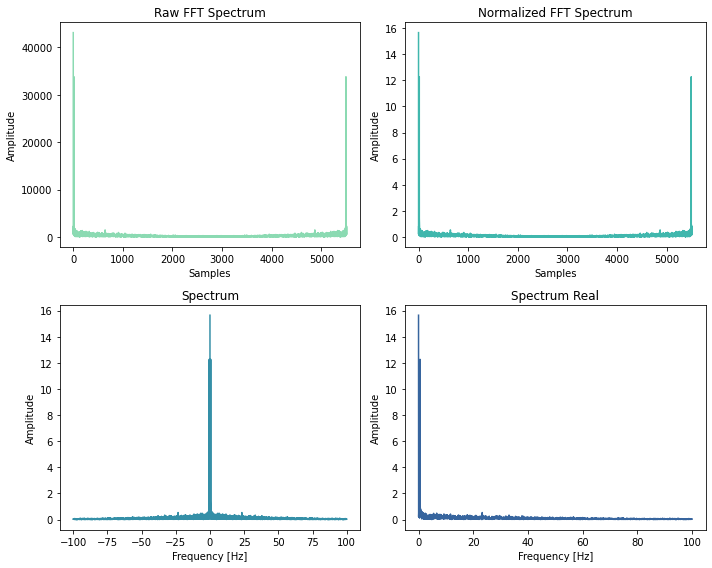

In [22]:
## take a look at fft
## https://towardsdatascience.com/fourier-transform-the-practical-python-implementation-acdd32f1b96a

signal = np.array(Ithaca_daily_train.T_AVG)
T = len(signal)
normalize = T/2
fft_result = fft(signal)
sampling_rate = 200
frequency_axis = fftfreq(T, d = 1.0/sampling_rate)
norm_amplitude = np.abs(fft_result)/normalize
freq = rfftfreq(T, d = 1/sampling_rate)

fig, ax = plt.subplots(2,2, figsize = (10,8))

# the spectrum |Xk|
ax[0,0].plot(np.abs(fft_result), color = palette[0])
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_xlabel('Samples')
ax[0,0].set_title('Raw FFT Spectrum')

# Plot the normalized FFT (|Xk|)/(N/2)
ax[0,1].plot(norm_amplitude, color = palette[1])
ax[0,1].set_ylabel('Amplitude')
ax[0,1].set_xlabel('Samples')
ax[0,1].set_title('Normalized FFT Spectrum')

# Plot frequency vs. amplitude
ax[1,0].plot(frequency_axis, norm_amplitude, color = palette[2])
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_xlabel('Frequency [Hz]')
ax[1,0].set_title('Spectrum')

# Plot only the spectrum for real-values signal data
ax[1,1].plot(freq, 2*np.abs(rfft(signal))/T, color = palette[3])
ax[1,1].set_ylabel('Amplitude')
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].set_title('Spectrum Real')
plt.tight_layout()


fig.savefig('fft.png', bbox_inches = 'tight')

###### TODO: fit seasonality with frequencies extracted by FFT


##### 3.2.2 Just use apparent cycles

In [23]:
## assume omega = 2*pi/365
## https://www.youtube.com/watch?v=sa7E9qUHYXw&ab_channel=QuantPy
## we'are using the curve_fit to solve for non-linear fitting problem

# amptitude, shift, intercept
def trig_season(x, a, b, c):
  # a, b, c = params
  return a* np.sin(2*np.pi/365 *x + b) + c

params, param_cov = optimize.curve_fit(f = trig_season,
                   xdata = np.arange(len(Ithaca_daily_train)),
                   ydata = np.array(Ithaca_daily_train.T_AVG))
params

array([-12.58814597,   6.4131982 ,   7.85780641])

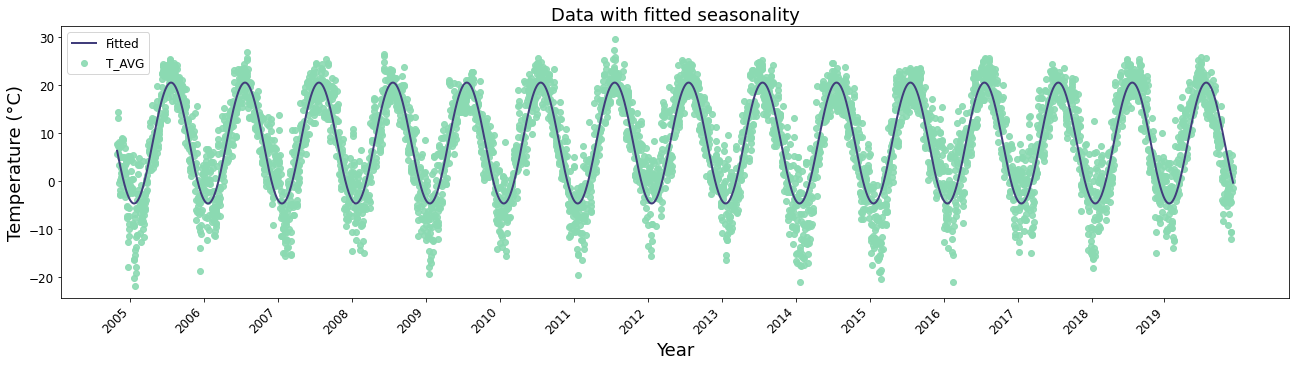

In [24]:
## plot
fig, ax = plt.subplots(1,1, figsize = (22,5))

fontsize = 18
labelsize = 12
colors = ['#7fcdbb', '#2c7fb8']
palette = sns.color_palette("mako_r", 6)
df = Ithaca_daily_train
col = 'T_AVG'
years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

ax.set_title('Data with fitted seasonality', fontsize=fontsize)
ax.scatter(df.index, df.T_AVG, label='T_AVG', color = palette[0], alpha = 0.9)
ax.plot(df.index, trig_season(df.index, params[0], params[1], params[2]), color = palette[-2], lw = 2, label = 'Fitted')
ax.set_xticklabels([])
ax.set_xticks(years[1:])
ax.set_xticklabels(years_txt[1:], rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=fontsize)
ax.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
ax.legend(fontsize=12)
fig.savefig('Trig_data.png')

##### 3.3 subtract seasonality, ADF, triplot

In [25]:
## subtract seasonality, adf test
Ithaca_daily_train['T_AVG_trig_sub'] = Ithaca_daily_train.T_AVG - trig_season(Ithaca_daily_train.index, params[0], params[1], params[2])
Ithaca_daily_val['T_AVG_trig_sub'] = Ithaca_daily_val.T_AVG - trig_season(Ithaca_daily_val.index, params[0], params[1], params[2])

# adf test
adfuller(Ithaca_daily_train.T_AVG_trig_sub)

(-11.489487324061429,
 4.774907018307936e-21,
 19,
 5490,
 {'1%': -3.4315416867385533,
  '5%': -2.862066607021651,
  '10%': -2.5670503117773333},
 28966.629742872417)

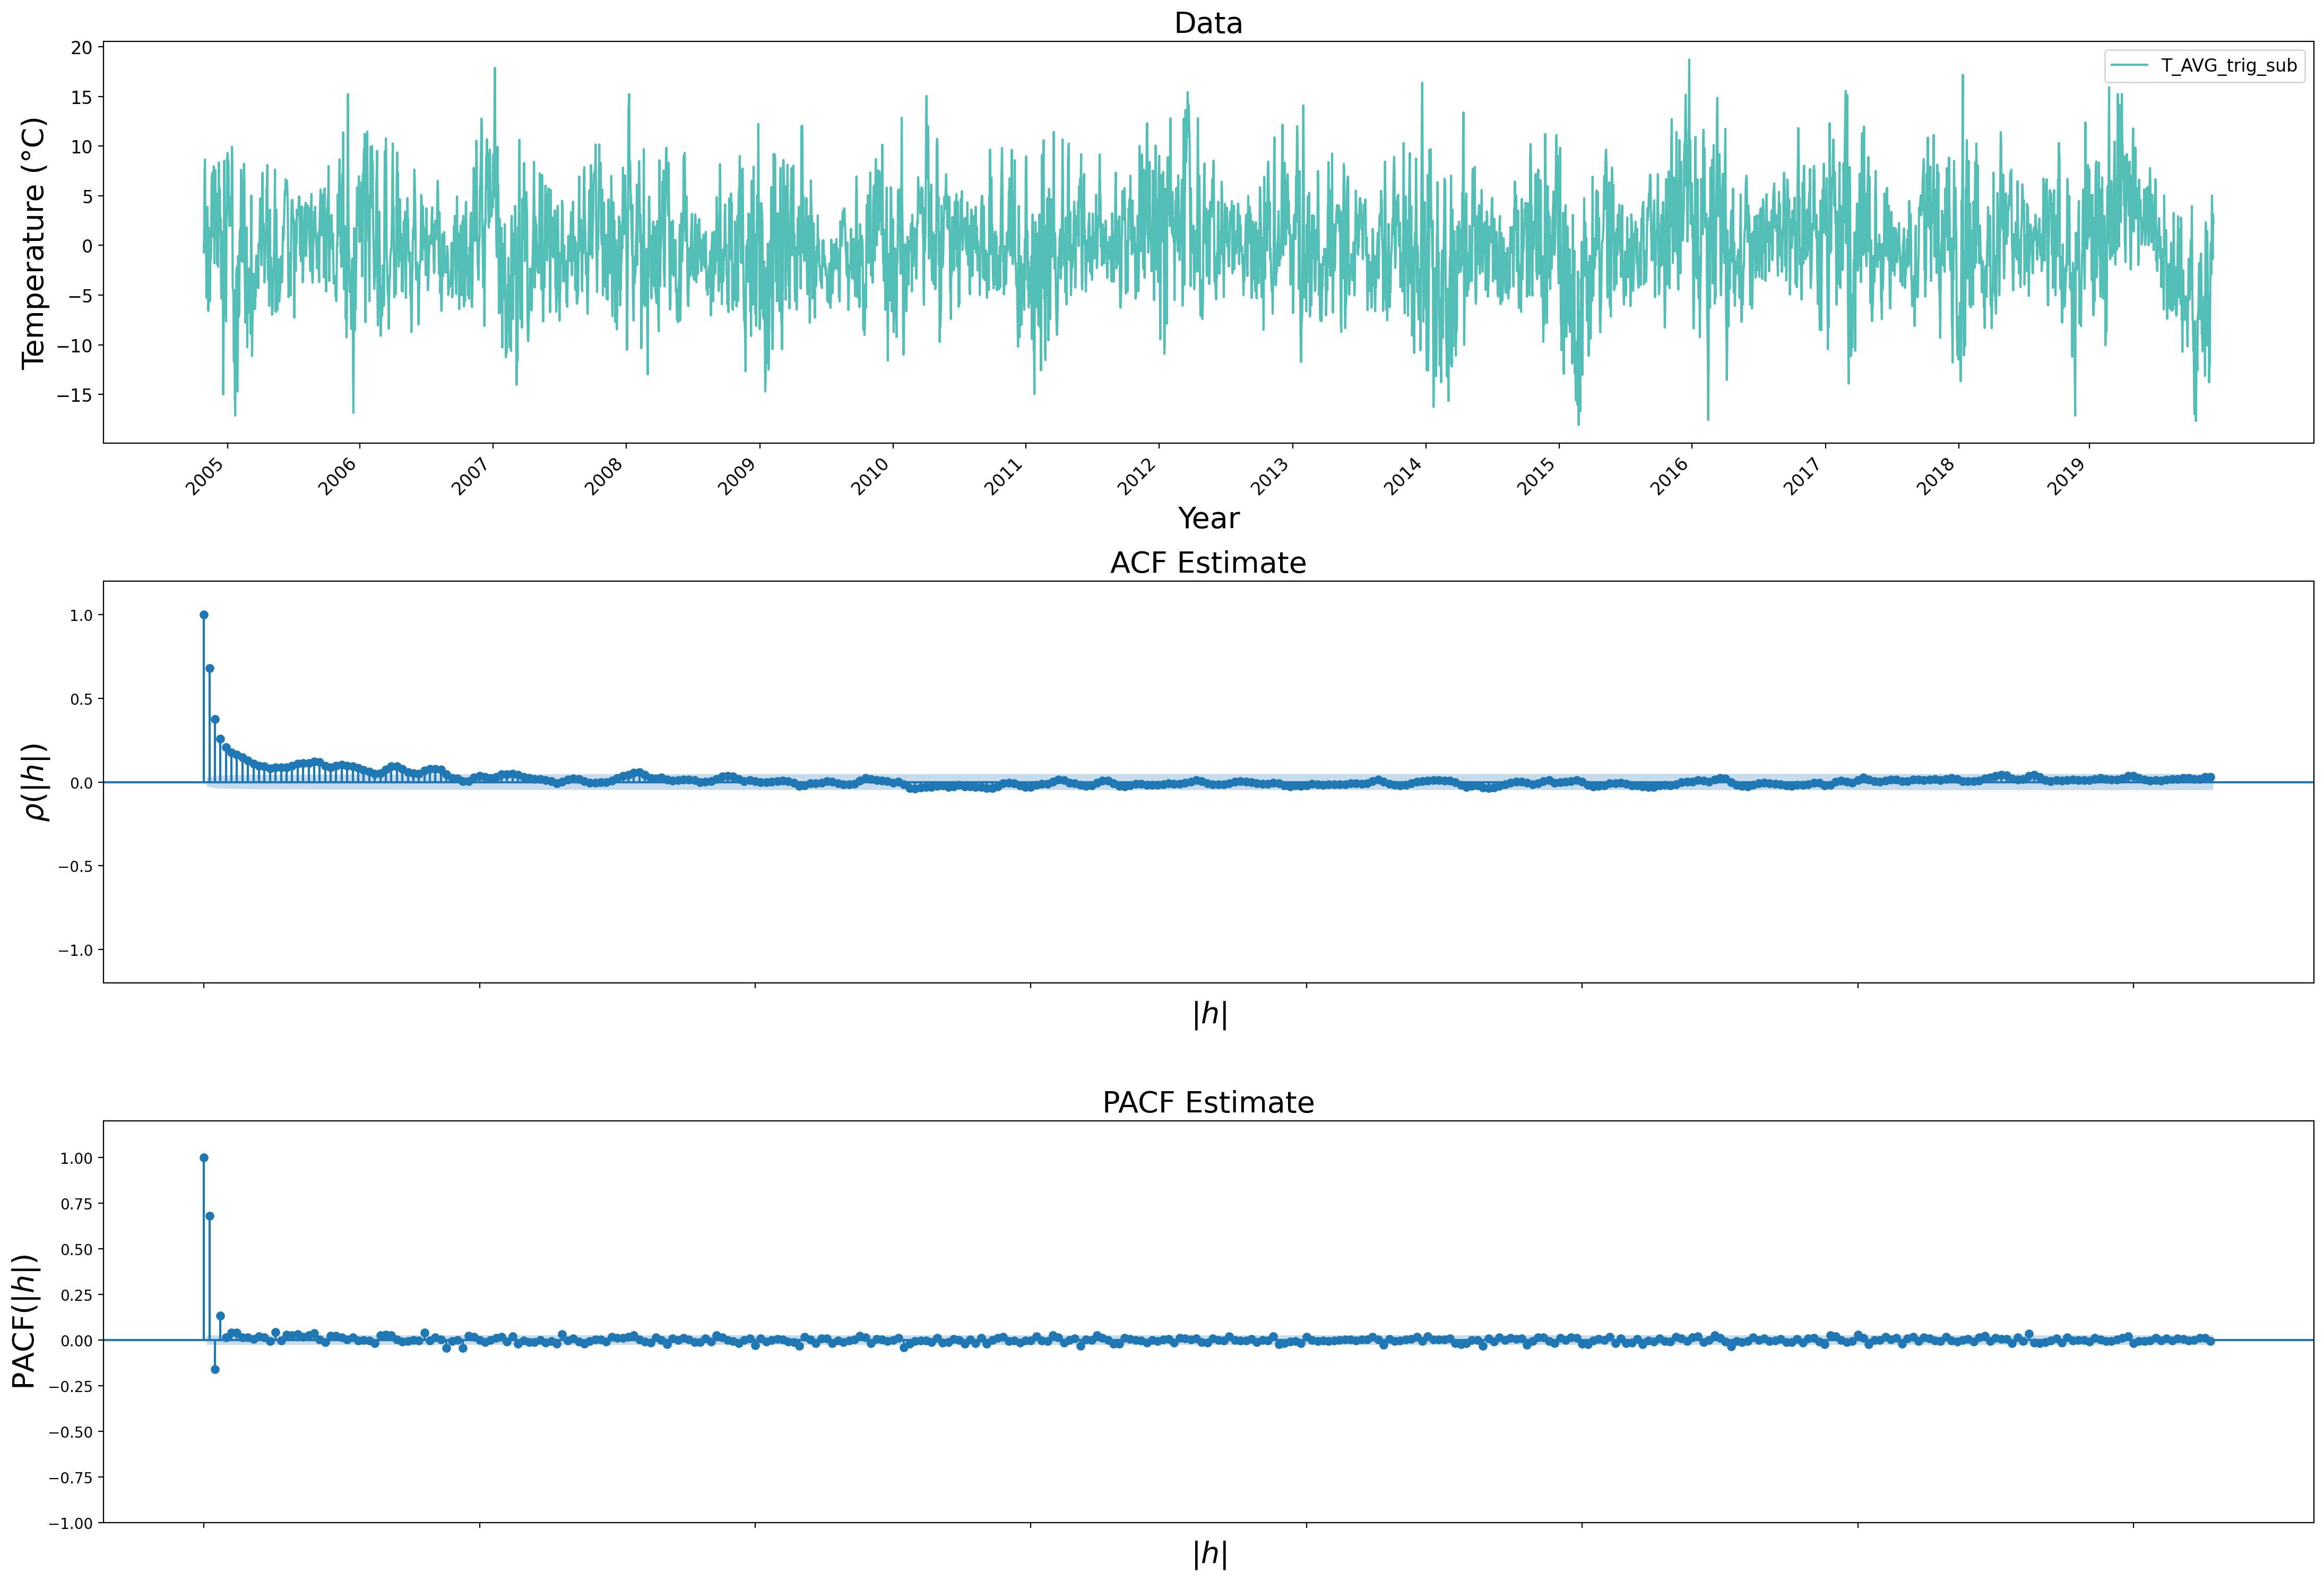

In [26]:
## triplot
seasonality = 365
plot_triple_built_in(df = Ithaca_daily_train,
                     n_lags_ar = seasonality, n_lags_ma = seasonality,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_AVG_trig_sub',fig_name = 'daily_nonseasonal_p_q')

# Don't think it is better than simply subtract T-365, etc.
# If we are dropping seasonal P, Q due to computational cost, what's the use of simple trig transform?

##### 3.4 model search

In [ ]:
p, q, d = range(2,4), range(8,10,2), range(0,1)
config_list = list(itertools.product(p, d, q))
scores = grid_search(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_trig_sub',
                     n_val = len(Ithaca_daily_val), cfg_list = config_list, parallel = False)


In [ ]:
## > Model[(0, 0, 1)] 4.5253
## > Model[(0, 0, 2)] 4.0678
## > Model[(0, 0, 3)] 3.9000
## > Model[(1, 0, 0)] 3.6928
## > Model[(1, 0, 1)] 3.7203
## > Model[(1, 0, 2)] 3.5966
## > Model[(1, 0, 3)] 3.4710
## > Model[(2, 0, 0)] 3.7281
## > Model[(2, 0, 1)] 3.6881
## > Model[(2, 0, 2)] 3.4423
## > Model[(2, 0, 3)] 3.4434
## > Model[(3, 0, 0)] 3.6195
## > Model[(3, 0, 1)] 3.4625
## > Model[(3, 0, 2)] 3.4430
## > Model[(3, 0, 3)] 3.4429
## > Model[(2, 0, 4)] 3.4446
## > Model[(2, 0, 6)] 3.4492
## > Model[(2, 0, 8)] 3.4478
##
##
##

##### 3.5 tentative model fitting

In [27]:
## currently, within the limited search space, I find (p,d,q) = (2,0,2) return the best walk-forward validation rmse.
## Since I only include train & val set. I'll refit the model, report residuals, plot graphs.
cfg = (2, 0, 2)
# key, res = score_model(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_trig_sub',
#                        n_val, cfg = len(Ithaca_daily_val), debug=False, save = True)
# I already ran this model and stored results, so just load

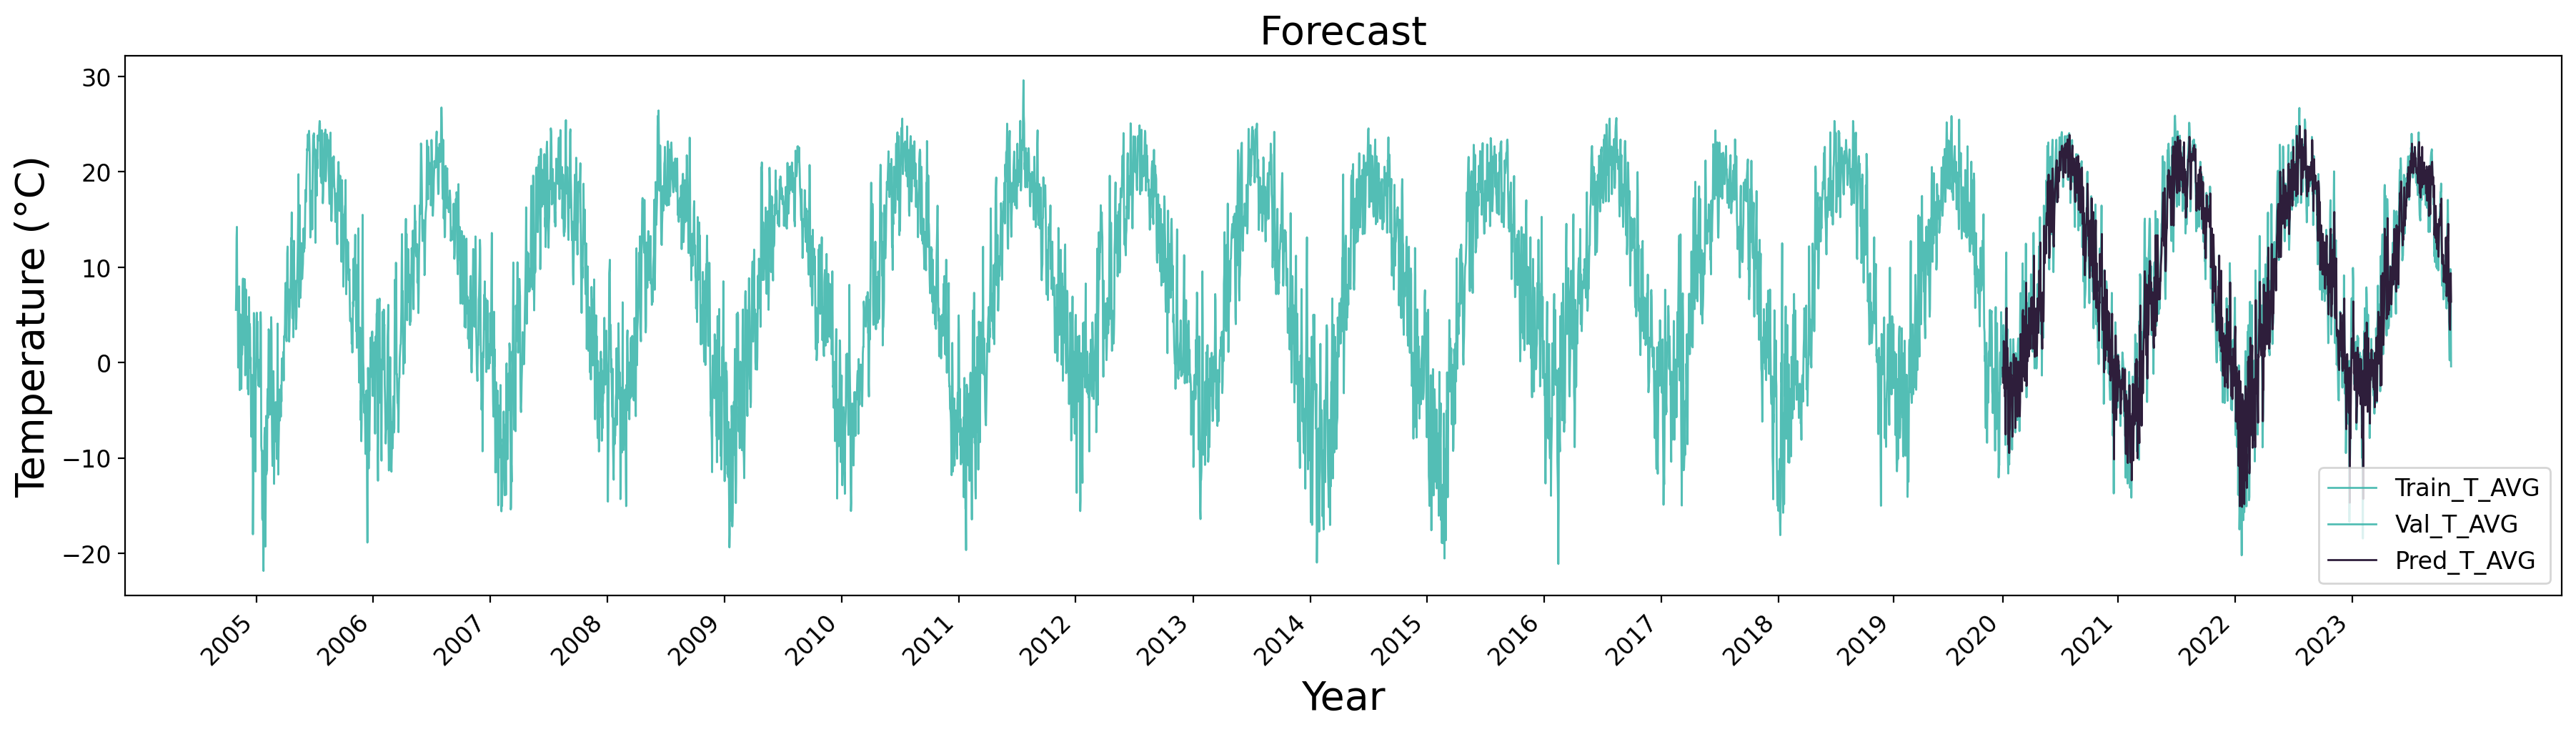

In [28]:
preds = np.load(f'arma_{cfg}_predictions.npy')
preds_add_season = preds + trig_season(Ithaca_daily_val.index, params[0], params[1], params[2])
preds_add_season = np.array(preds_add_season).reshape(-1,1)

plot_forecast(Ithaca_daily_train, Ithaca_daily_val, preds_add_season, 
              n_from_train_end = len(Ithaca_daily_train), n_from_val_start = len(Ithaca_daily_val),
             col = 'T_AVG', pred_col = 'T_AVG', save = False)

### Random Trial

In [ ]:
## Let's aggregate by month
nyc_monthly = nyc_daily_drop.groupby(['year','month']).mean()
nyc_monthly.reset_index(inplace = True)

fontsize = 12
fig_overall, ax = plt.subplots(1,1, figsize = (12,4))
sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMAX'],
              color = palette[1], label = 'TMAX', alpha = 0.9)
# sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMIN'],
#               color = palette[-1], label = 'TMIN', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks([])
ax.tick_params(axis = 'y', labelsize = 10)
ax.set_ylabel('Temperature (°F)', fontsize = fontsize)
ax.set_xlabel('Date', fontsize = fontsize)
ax.legend(fontsize = 12)
plt.show()

In [ ]:
nyc_monthly.index

In [ ]:
## cp output to drive
!scp *.png drive/MyDrive/Colab\ Notebooks/

##### Failed auto_arima

In [ ]:
## Does not work. running for 47 mins without result
## search for the best model
# Or maybe just use auto_arima
# P <= 3, Q <= 1; p <= 3, q <= 27

res = pm.auto_arima(Ithaca_daily_train.T_AVG, d = 0,
                    start_p = 1,
                    start_q = 1,
                    max_p = 3,
                    max_q = 5,
                    seasonal = True,
                    m = 365,
                    D = 1,
                    start_P = 1,
                    start_Q = 1,
                    max_P = 3,
                    max_Q = 1,
                    information_criterion='aic')

##### Failed SARIMAX

In [ ]:
## search for the best model
# P <= 3, Q <= 1; p <= 3, q <= 27 -> impossible to solve for such a range. so truncate.
# Note large q won't work. Computationally expensive.

# modified utils from the following sources
# https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/
# https://www.kaggle.com/code/leandrovrabelo/climate-change-forecast-sarima-model/notebook

order_aic = [] # store AIC per model here. Complementary to CV
# forecast function
def sarima_forecast(history, config, aic = True):
    """
    order = (p,d,q)
    sorder = (P,D,Q,s)
    """
    order, sorder = config[:3], config[3:]
    # define model
    model = sarimax.SARIMAX(history, order=order,
                          seasonal_order=sorder,

                          trend=None, enforce_stationarity=False,
                          enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False) # do not print convergence message
    if aic:
      order_aic += [(config, model_fit.aic)]
    # make one step forecast
    yhat = model_fit.predict(start = len(history), end = len(history))
    return yhat[0]


# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(train, val, col, n_val, cfg):
      predictions = np.zeros(len(val))
      # seed history with training dataset
      history = list(train['col'])
      # step over each time-step in the test set
      for i in range(len(val)):
      # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions[i] = yhat
        # add actual observation to history for the next loop
        history.append(val[i])
        # estimate prediction error
        error = measure_rmse(val, predictions)
      return error


# score a model, return None on failure
def score_model(train, val, col, n_val, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(train, val, col, n_val, cfg)
    else:
      try:
    # never show warnings when grid searching, too noisy
          with catch_warnings():
            warnings.filterwarnings("ignore")
            result = walk_forward_validation(train, val, col, n_val, cfg)
      except:
          error = None
    # check for an interesting result
    if result is not None:
      print(' > Model[%s] %.4f' % (key, result))
    return (key, result)


# we need to set to sarimax gridsearch
def grid_search(train, val, col, n_val, cfg_list, parallel=True):
    scores = None
    if parallel:
 # execute configs in parallel
      executor = Parallel(n_jobs=-1, backend='multiprocessing')
      tasks = (delayed(score_model)(train, val, col, n_val, cfg) for cfg in cfg_list)
      scores = executor(tasks)
    else:
      scores = [score_model(train, val, col, n_val, cfg) for cfg in cfg_list]
      # remove empty results
      scores = [r for r in scores if r[1] != None]
      # sort configs by error, asc
      scores.sort(key=lambda x: x[1])
    return scores



In [ ]:
P, Q, p, q, D, s, d = range(0,4), range(1,2), range(1,2), range(1,2), range(1,2), range(365,366), range(0,1)
config_list = list(itertools.product(p, d, q, P, D, Q, s))
scores = grid_search(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG',
                     n_val = len(Ithaca_daily_val), cfg_list = config_list, parallel = True)

In [ ]:
sarima_forecast(history = list(Ithaca_daily_train['T_AVG']), config = config_list[0]) # it is not feasible... too slow...
# Let's just try Fourier Transform first, then ARMA

In [ ]:
walk_forward_validation(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_trig_sub',
                        n_val = len(Ithaca_daily_val), cfg = config_list[1])